In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow import keras
import sys
import PIL
import os
import tensorflow.keras.backend as K
import sys
sys.path.append('../scripts/helper_functions_cv/tensorflow_helpers/')
from gpu_starter_mirror_strategy import start_gpus
from tqdm import tqdm
tqdm.pandas()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from dotenv import load_dotenv
from save_weights_every_epoch import CallbackForSavingModelWeights

2023-03-08 21:52:47.690891: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
strategy, REPLICAS, AUTO = start_gpus([0])

2023-03-08 21:52:49.431733: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 21:52:49.459496: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 21:52:49.460322: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-08 21:52:49.462017: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Returning objects as strategy, replicas and auto in same order.


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
train_csv = pd.read_csv('../data/train.csv')

In [5]:
train_csv.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [6]:
train_csv['updated_paths'] = train_csv['image'].progress_apply(lambda x: '../data/train_images/' + x)

100%|██████████| 18632/18632 [00:00<00:00, 1034131.35it/s]


In [7]:
train_csv.head()

,image,labels,updated_paths
0,800113bb65efe69e.jpg,healthy,../data/train_images/800113bb65efe69e.jpg
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex,../data/train_images/8002cb321f8bfcdf.jpg
2,80070f7fb5e2ccaa.jpg,scab,../data/train_images/80070f7fb5e2ccaa.jpg
3,80077517781fb94f.jpg,scab,../data/train_images/80077517781fb94f.jpg
4,800cbf0ff87721f8.jpg,complex,../data/train_images/800cbf0ff87721f8.jpg


In [8]:
def check_paths(csv_file):
    paths = csv_file['updated_paths'].values.tolist()
    for path in paths:
        assert os.path.exists(path) == True, 'Path does not exist.'
check_paths(train_csv)

In [9]:
def plot_grpahs(csv_file):
    diseases = csv_file['labels'].value_counts().keys()
    disease_count = csv_file['labels'].value_counts().values
    percentages = [round((x / sum(disease_count)), 2) * 100 for x in disease_count]
    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (25,15)
    bar_var = plt.bar(diseases, disease_count)
    for p in range(len(bar_var)):
        height = bar_var[p].get_height()
        ax.annotate('{}'.format(percentages[p]),
            xy=(bar_var[p].get_x() + bar_var[p].get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha='center', va='bottom')

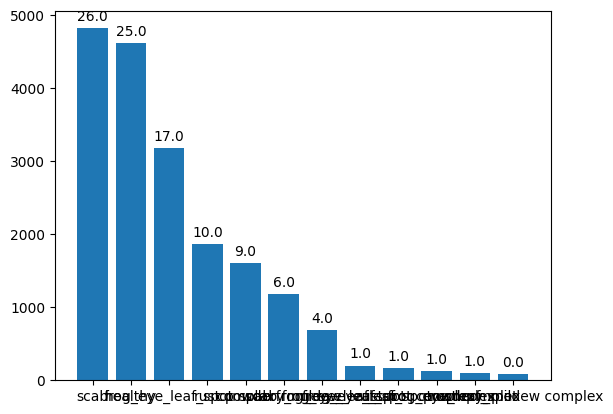

In [10]:
plot_grpahs(train_csv)

In [11]:
def label_encoders(csv_file):
    labels = csv_file['labels'].values.tolist()
    label_encoder = LabelEncoder()
    transformed = label_encoder.fit_transform(labels)
    return transformed, label_encoder

In [12]:
label_encoded, label_transformer = label_encoders(train_csv)
train_csv['labels_encoded'] = label_encoded

In [13]:
def split_datasets(csv_file, test_size):
    train, test = train_test_split(csv_file, test_size=test_size, random_state=42)
    train, val = train_test_split(csv_file, test_size=test_size, random_state=42)
    return train, val, test

In [14]:
train, val, test = split_datasets(train_csv, 0.08)

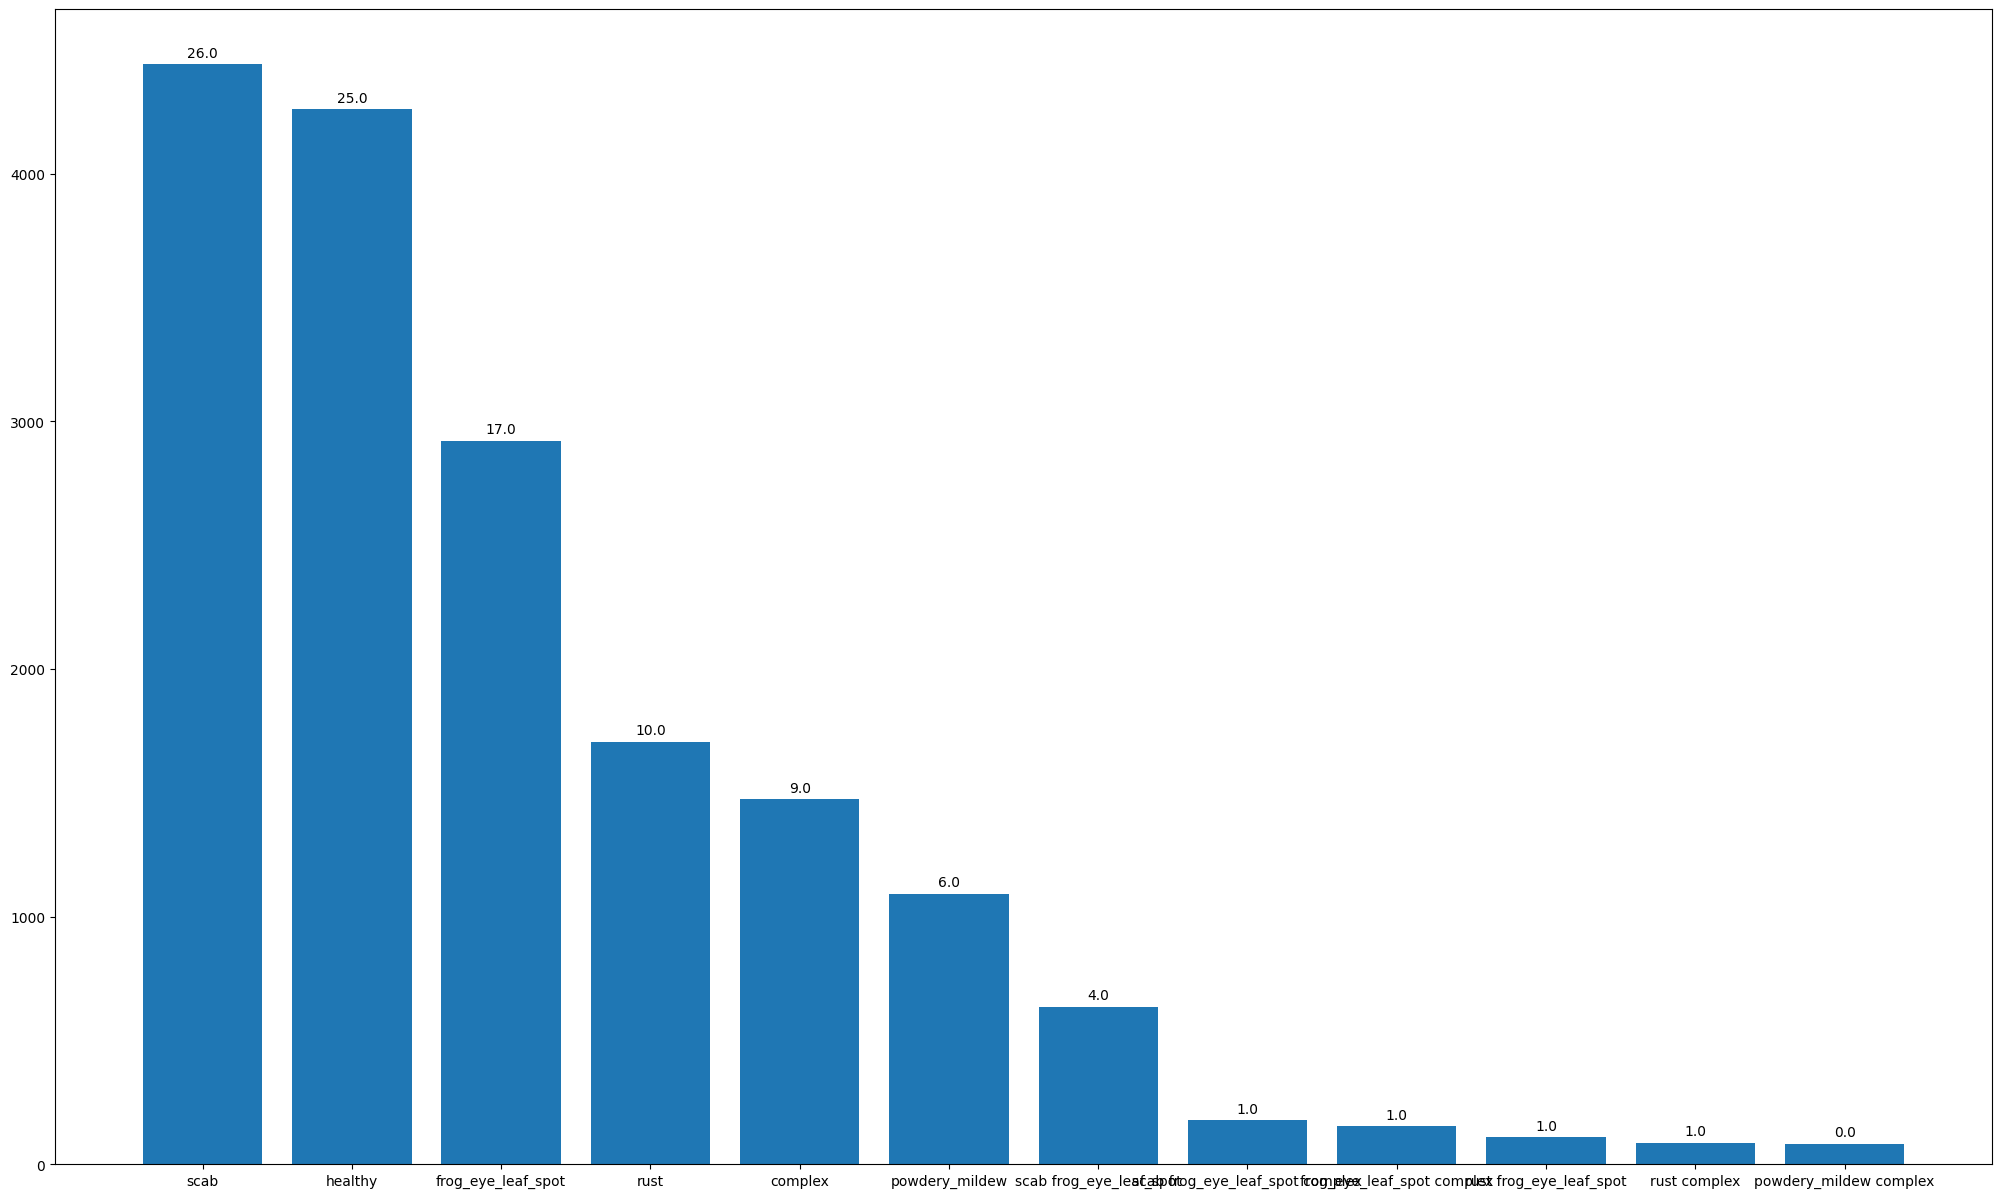

In [15]:
plot_grpahs(train)

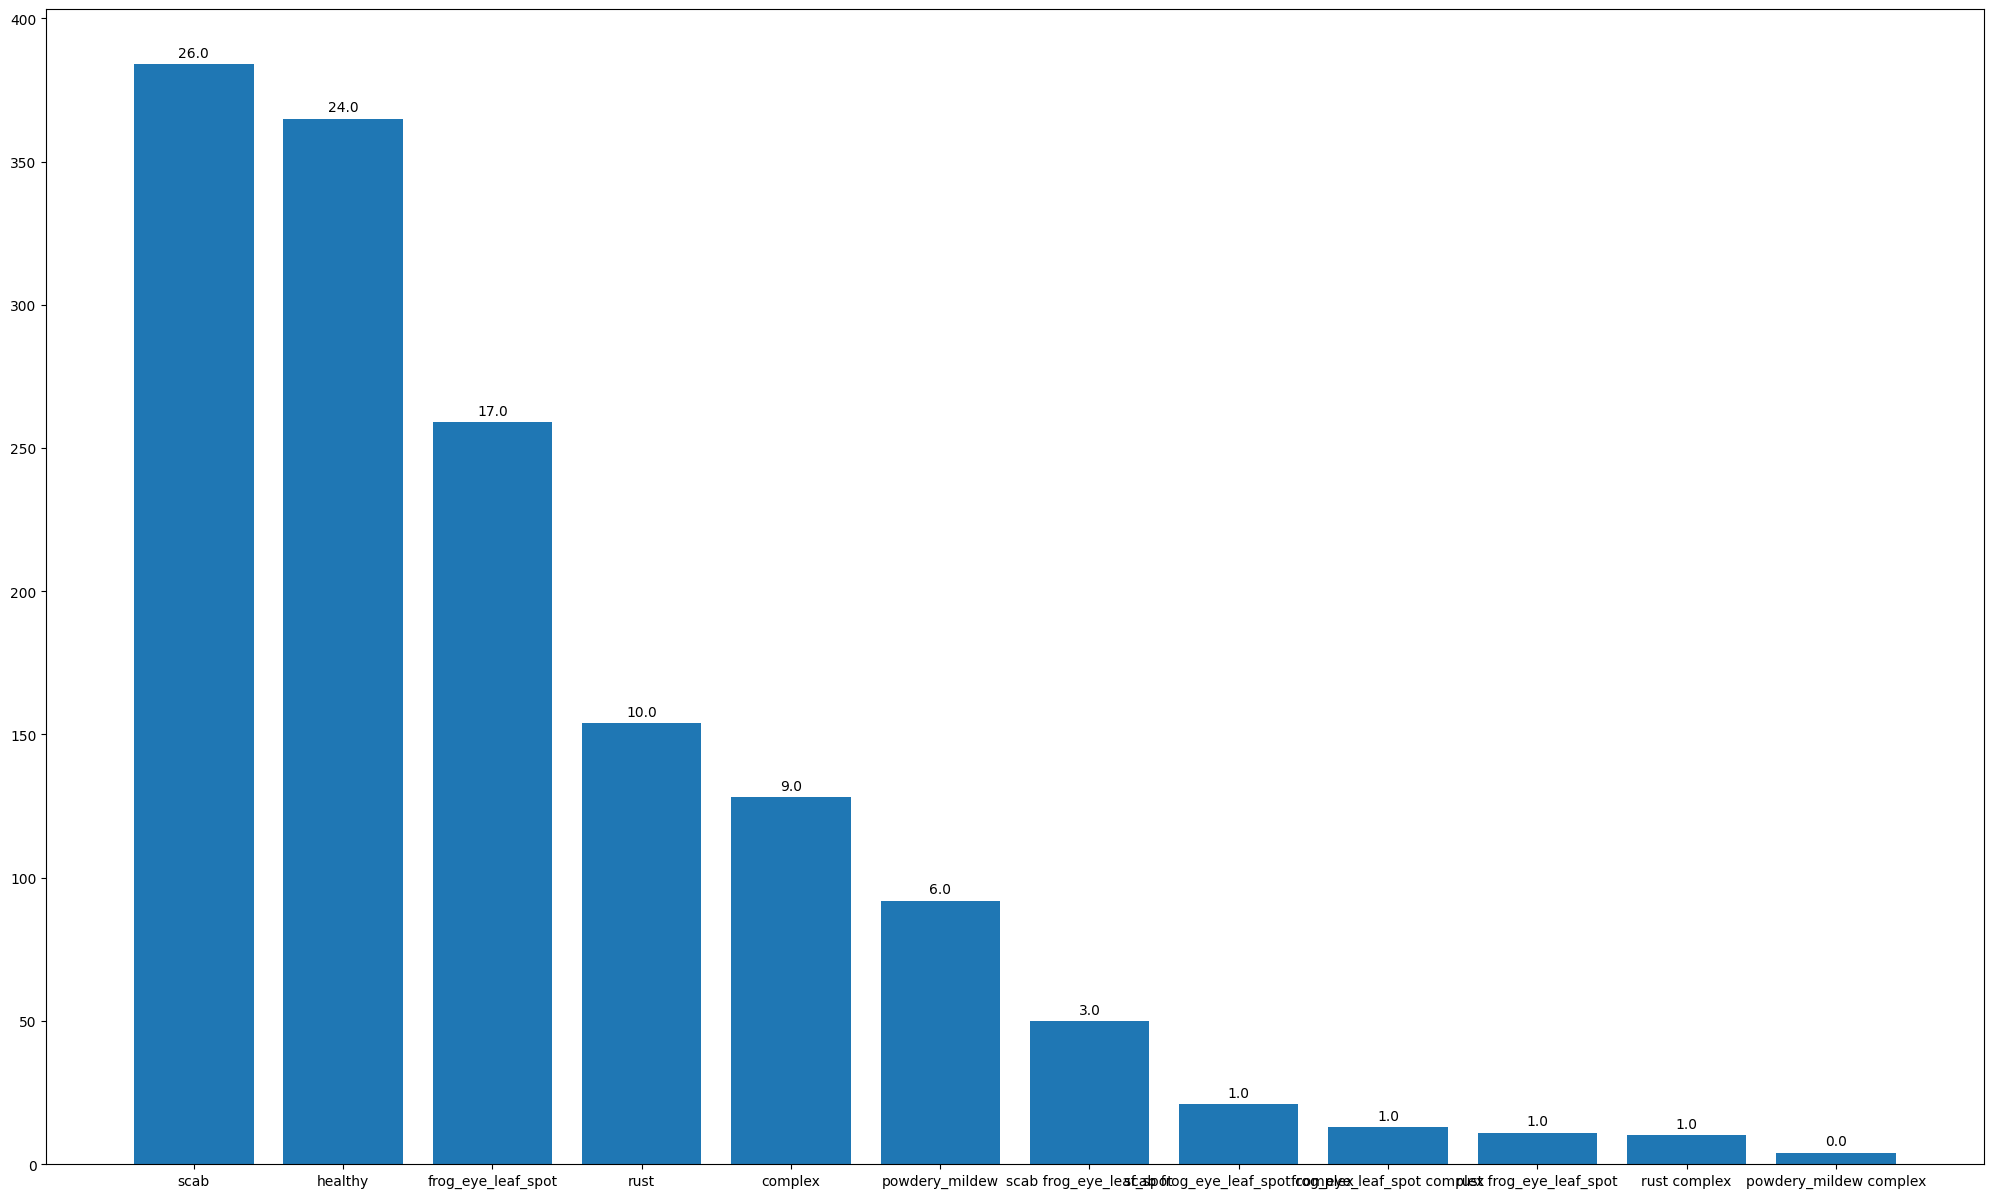

In [16]:
plot_grpahs(val)

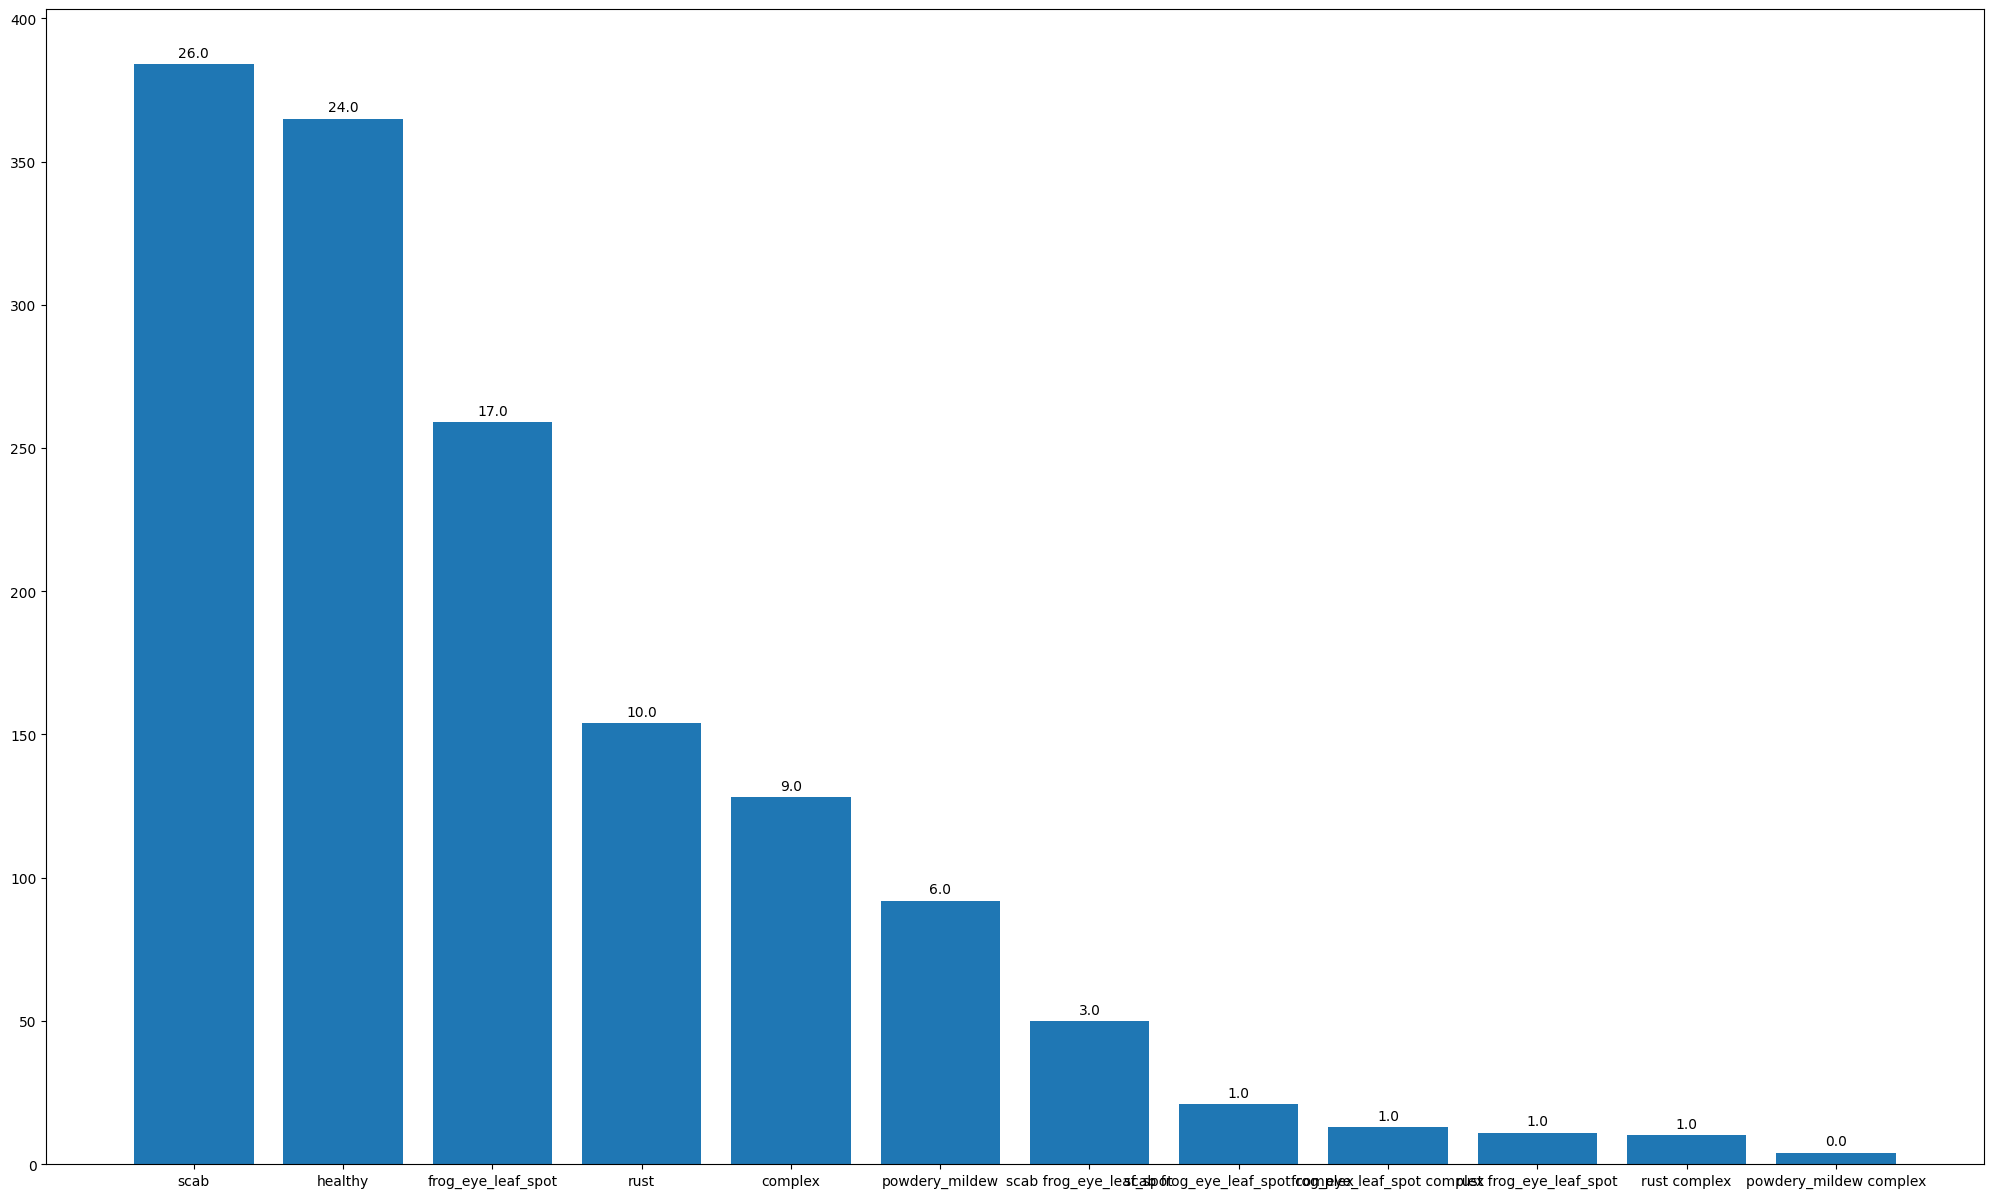

In [17]:
plot_grpahs(test)

In [18]:
tf.one_hot(3, depth=4)

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0., 0., 0., 1.], dtype=float32)>

In [19]:
train.head()

,image,labels,updated_paths,labels_encoded
7563,b58ac089edbd2eb0.jpg,healthy,../data/train_images/b58ac089edbd2eb0.jpg,3
8955,bfc002ff819f4b09.jpg,scab,../data/train_images/bfc002ff819f4b09.jpg,9
12865,d9e3cc33269f2708.jpg,rust,../data/train_images/d9e3cc33269f2708.jpg,6
8660,bdb5f66202366073.jpg,frog_eye_leaf_spot,../data/train_images/bdb5f66202366073.jpg,1
18504,ff83ac241bab48c6.jpg,frog_eye_leaf_spot,../data/train_images/ff83ac241bab48c6.jpg,1


In [20]:
len(train_csv['labels'].value_counts())

12

In [21]:
def read_train_imgs(img, label):
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size = (256, 256))
    img = img / 255
    label = tf.one_hot(label, depth = 12)
    return img, label

In [22]:
def get_data(**kwargs):
    imgs = kwargs['csv_file']['updated_paths'].values.tolist()
    labels = kwargs['csv_file']['labels_encoded'].values.tolist()
    tensor = tf.data.Dataset.from_tensor_slices((imgs, labels))
    tensor = tensor.cache()
    if kwargs['repeat']:
        tensor = tensor.repeat()
    if kwargs['shuffle']:
        tensor = tensor.shuffle(1024 * REPLICAS)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        tensor = tensor.with_options(opt)
    tensor = tensor.map(read_train_imgs, num_parallel_calls = AUTO)
    if kwargs['batch']:
        tensor = tensor.batch(kwargs['batch_size'] * REPLICAS)
    if kwargs['prefetch']:
        tensor = tensor.prefetch(AUTO)
    return tensor

In [23]:
def create_new_model(model, shape):
    with strategy.scope():
        input = tf.keras.Input(shape = shape)
        dummpy_layer = tf.keras.layers.Lambda(lambda x: x)(input)
        # for x in range(len(models)):
        constructor = getattr(keras.applications, model)
        mode = constructor(include_top = False,
                            weights = None,
                            input_shape = shape,
                            pooling = 'avg',
                            )(dummpy_layer)
        output = tf.keras.layers.Dense(12, activation = 'sigmoid')(mode)
        model = tf.keras.Model(inputs=input, outputs=output, name='final_layer')
    return model
def compile_new_model(model):
    with strategy.scope():
        losses = tf.keras.losses.CategoricalCrossentropy()
        optimizer = tf.keras.optimizers.SGD()
        metrics = [tf.keras.metrics.Precision(name = 'Prec'), tf.keras.metrics.Recall(name = 'Rec')]
        model.compile(optimizer = optimizer, loss = losses, metrics = metrics)
    return model

In [26]:
weights_path = '../weights/'

In [33]:
res_weights = f'{weights_path}res50/'
save_weight = CallbackForSavingModelWeights(res_weights)
tb_path = '../TB/res50/'
if os.path.exists(tb_path) == False:
    os.makedirs(tb_path)
tb_callback = keras.callbacks.TensorBoard(tb_path)
args_dict_train = {
    'csv_file' : train,
    'repeat' : True,
    'shuffle' : True,
    'batch' : True,
    'batch_size' : 64,
    'prefetch' : True
}
train_dataset = get_data(**args_dict_train)
args_dict_val = {
    'csv_file' : val,
    'repeat' : False,
    'shuffle' : False,
    'batch' : True,
    'batch_size' : 64,
    'prefetch' : True
}
val_dataset = get_data(**args_dict_val)
model = create_new_model('ResNet50', (256, 256, 3))
model = compile_new_model(model)
steps_per_epoch = len(train) // (REPLICAS * 64)
model_hist = model.fit(train_dataset, 
                       validation_data = val_dataset,
                       steps_per_epoch = steps_per_epoch, 
                       epochs = 100, 
                       verbose = 1, 
                       callbacks = [tb_callback])

2023-03-08 22:00:23.075705: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 1/100


2023-03-08 22:00:23.563871: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 17141
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:132"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
      args {
     

267/267 [==============================] - ETA: 0s - loss: 2.0707 - Prec: 0.1550 - Rec: 0.9194

2023-03-08 22:01:39.961039: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 1491
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\026TensorSliceDataset:140"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
          type_id: TFT_STRING
        }
      }
      args {
      

267/267 [==============================] - 81s 274ms/step - loss: 2.0707 - Prec: 0.1550 - Rec: 0.9194 - val_loss: 2.3050 - val_Prec: 0.1991 - val_Rec: 0.8082
Epoch 2/100
267/267 [==============================] - 71s 266ms/step - loss: 1.6072 - Prec: 0.1717 - Rec: 0.9446 - val_loss: 2.7314 - val_Prec: 0.1931 - val_Rec: 0.8524
Epoch 3/100
267/267 [==============================] - 71s 267ms/step - loss: 1.4433 - Prec: 0.1711 - Rec: 0.9603 - val_loss: 1.6699 - val_Prec: 0.1559 - val_Rec: 0.9383
Epoch 4/100
267/267 [==============================] - 71s 267ms/step - loss: 1.2877 - Prec: 0.1729 - Rec: 0.9678 - val_loss: 2.3644 - val_Prec: 0.1633 - val_Rec: 0.8672
Epoch 5/100
267/267 [==============================] - 71s 267ms/step - loss: 1.0921 - Prec: 0.1801 - Rec: 0.9730 - val_loss: 1.7246 - val_Prec: 0.1625 - val_Rec: 0.9095
Epoch 6/100
267/267 [==============================] - 71s 267ms/step - loss: 0.9448 - Prec: 0.1867 - Rec: 0.9815 - val_loss: 6.7721 - val_Prec: 0.1365 - val_Rec:

In [ ]:
res_weights = f'{weights_path}res50/'
save_weight = CallbackForSavingModelWeights(res_weights)
tb_path = '../TB/res50/'
if os.path.exists(tb_path) == False:
    os.makedirs(tb_path)
tb_callback = keras.callbacks.TensorBoard(tb_path)
args_dict_train = {
    'csv_file' : train,
    'repeat' : True,
    'shuffle' : True,
    'batch' : True,
    'batch_size' : 64,
    'prefetch' : True
}
train_dataset = get_data(**args_dict_train)
args_dict_val = {
    'csv_file' : val,
    'repeat' : False,
    'shuffle' : False,
    'batch' : True,
    'batch_size' : 64,
    'prefetch' : True
}
val_dataset = get_data(**args_dict_val)
model = create_new_model('ResNet101', (256, 256, 3))
model = compile_new_model(model)
steps_per_epoch = len(train) // (REPLICAS * 64)
model_hist = model.fit(train_dataset, 
                       validation_data = val_dataset,
                       steps_per_epoch = steps_per_epoch, 
                       epochs = 100, 
                       verbose = 1, 
                       callbacks = [tb_callback])